
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/EffiSciencesResearch/hackathon42/blob/main/starting_pack_hackathon42.ipynb)


In [ ]:
# This can take a moment
# Please install git large file system before cloning
!git lfs install
!git clone https://github.com/EffiSciencesResearch/hackathon42.git

In [224]:
%cd /content/hackathon42

import numpy as np
from tqdm.notebook import tqdm
import os
from os.path import join
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F

use_cuda = False
device = torch.device("cuda" if use_cuda else "cpu")

datasets_names = sorted(os.listdir(path='datasets'), key=lambda name: int(name[:2]))
datasets_names = {int(datasets_name.split("_")[0]): datasets_name for datasets_name in datasets_names}
print(datasets_names)

# You can choose the dataset here by modifying the brackets
dataset_name = join('datasets', datasets_names[3])
#assert "01_mnist_cc" in dataset_name, "This colab is destined for MNIST, and not for the other datasets. The code needs to be adapted :) "
print(dataset_name)

X_labeled = np.load(join(dataset_name, "X_labeled.npy"))
y_labeled = np.load(join(dataset_name, "y_labeled.npy"))
X_unlabeled = np.load(join(dataset_name, "X_unlabeled.npy"))
X_val = np.load(join(dataset_name, "X_val.npy"))


x_train, x_test, y_train, y_test = train_test_split(X_labeled, y_labeled)

#X_train = torch.tensor(x_train, device=device).float()
#X_test = torch.tensor(x_test, device=device).float()

X_train = torch.tensor(x_train[:, :,:,:28] + x_train[:, :,:,28:], device=device).float()
X_test_tmp = torch.tensor(x_test, device=device).float()
X_test = torch.tensor(x_test[:, :,:,:28]+x_train[:, :,:,28:], device=device).float()

y_train = torch.tensor(y_train, device=device)
y_test = torch.tensor(y_test, device=device)

/content/hackathon42
{0: '00_toy_dataset', 1: '01_mnist_cc', 2: '02_mnist_constant_image', 3: '03_mnist_constant_image_random_row', 4: '04_mnist_uniform_color_random_row', 5: '05_mnist_uniform_color_low_mix_rate', 6: '06_mnist_sum', 8: '08_mnist_sum_noise_level', 12: '12_mnist_mysterious', 13: '13_mnist_mysterious', 23: '23_mnist_embed', 456: '456_mnist_embed', 888: '888_vehicle_animal', 999: '999_humans'}
datasets/03_mnist_constant_image_random_row


ValueError: ignored

In [220]:
class NeuralNetwork(nn.Module):
    def __init__(self, n_classes=2):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 400),
            nn.ReLU(),
            nn.Linear(400, 300),
            nn.ReLU(),
            nn.Linear(300, 200),
            nn.ReLU(),
            nn.Linear(200, 4),
        )
    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits
net = NeuralNetwork().to(device)

In [222]:
import pandas as pd

tbatch = 150
nb_epochs = 50
nbbatchs = int(X_train.shape[0]/tbatch)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.01)

net.train()

def evaluate(X_test):
    net.eval()
    with torch.no_grad():
        y_pred = net(X_test)
    correct_test = (torch.argmax(y_pred, axis=1) == y_test).sum().item()
    net.train()
    return correct_test/len(X_test)

for epoch in tqdm(range(nb_epochs)):  # loop over the dataset multiple times
    correct = 0
    for i in (range(nbbatchs)):
        
        optimizer.zero_grad()
        
        X_batch = X_train[i*tbatch:(i+1)*tbatch]
        y_batch = y_train[i*tbatch:(i+1)*tbatch]

        # Compute forward / backward
        y_pred = net(X_batch)
        correct += (torch.argmax(y_pred, axis=1) == y_batch).sum().item()

        loss = criterion(y_pred, y_batch)
        
        loss.backward()
        optimizer.step()
        # break
    print("acc train:", correct/X_train.shape[0], "acc test:", evaluate(X_test))

  0%|          | 0/50 [00:00<?, ?it/s]

acc train: 0.995575221238938 acc test: 0.9933774834437086
acc train: 0.9944690265486725 acc test: 0.9900662251655629
acc train: 0.9922566371681416 acc test: 0.9933774834437086


KeyboardInterrupt: ignored

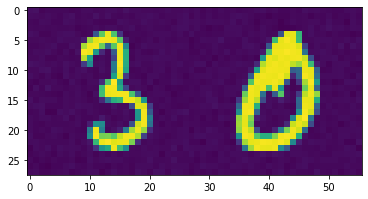

0 tensor(0)



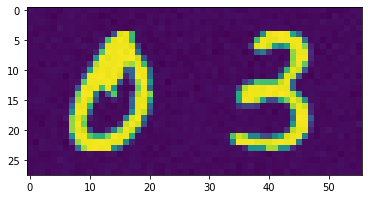

1 tensor(3)



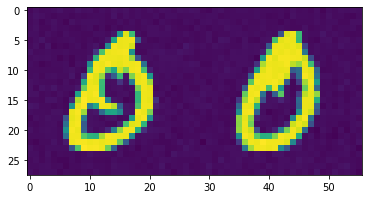

2 tensor(0)



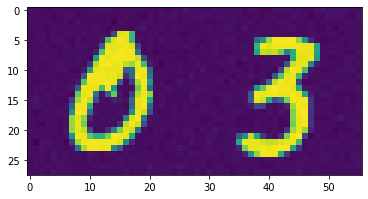

3 tensor(3)



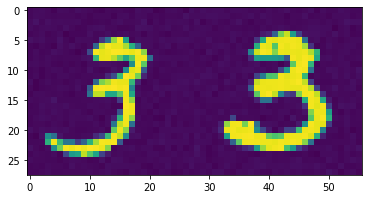

4 tensor(3)



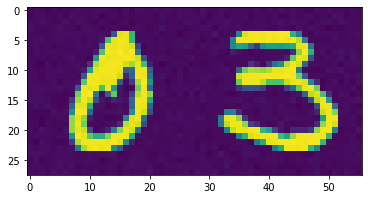

5 tensor(3)



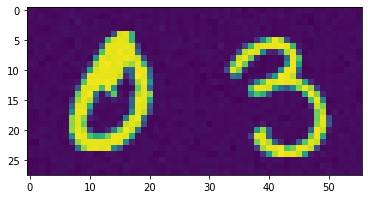

6 tensor(3)



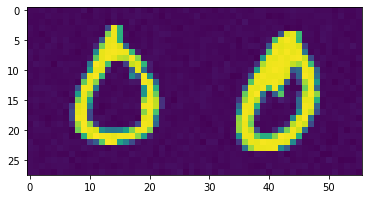

7 tensor(0)



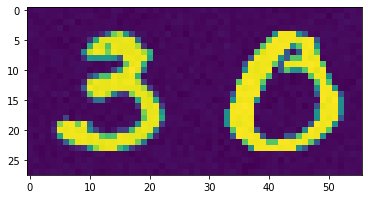

8 tensor(0)



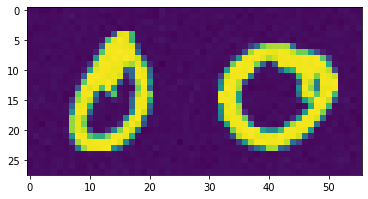

9 tensor(0)



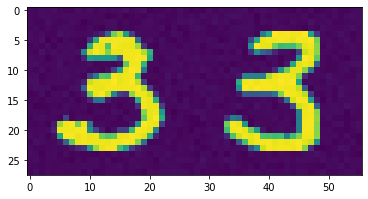

10 tensor(3)



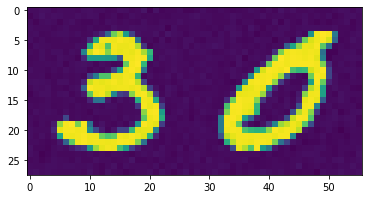

11 tensor(0)



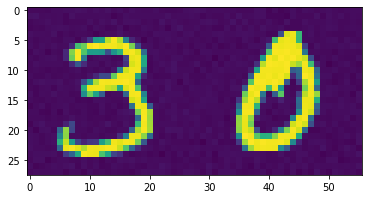

12 tensor(0)



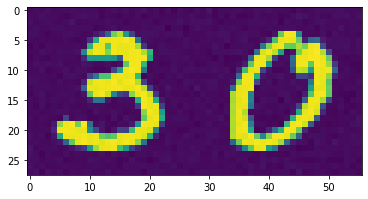

13 tensor(0)



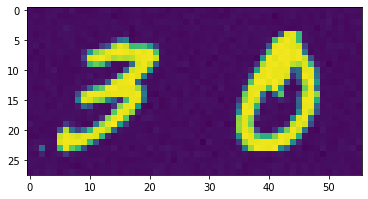

14 tensor(0)



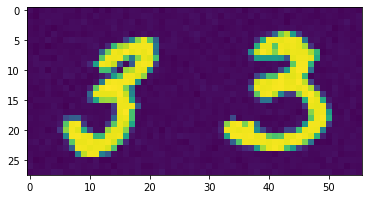

15 tensor(3)



KeyboardInterrupt: ignored

In [223]:
import matplotlib.pyplot as plt

X_show = torch.tensor(X_val[:,:,:,28:], device=device).float()
X_show_tmp = torch.tensor(X_val, device=device).float()

y_show = torch.argmax(net(X_show), axis=1)

y_pred = net(X_batch)
correct += (torch.argmax(y_pred, axis=1) == y_batch).sum().item()

for i in range(2000):
    plt.imshow(X_show_tmp[i, 0,:])
    plt.show()
    print(i, y_show[i])
    print("")

In [212]:
# net.train()
# with torch.no_grad():
    # y_pred = net(X_test)


# print(y_pred.shape)
# pred = torch.argmax(y_pred, dim=1)

pred = y_show.numpy()
df = pd.DataFrame(pred)
df.to_csv("02_mnist_constant_image.csv", header=False, index=False)